# Imports

In [133]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
import feature_engine.imputation as imp

# to split the datasets
from sklearn.model_selection import train_test_split

In [134]:
DATA_PATH = "../data/fake_job_postings.csv"

# Read Data

In [135]:
df = pd.read_csv(DATA_PATH)
df.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


# Preprocessing

#### Profile Report:

In [136]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Job_Id is a number from 1 upwards and therefore has no value for the machine learning algorithms

In [137]:
df.drop(columns=['job_id'], inplace=True)

#### Feature Categories

In [138]:
# consists of values from 0 to 1
binary_features = ['telecommuting', 'has_company_logo', 'has_questions']
# consists of text
text_features = ['title', 'company_profile', 'description', 'requirements', 'benefits']
# consists of text, symbols and numbers (not easy to process), and is therefore complex and has to be processed individually
complex_features = ['location', 'salary_range']
# consists of categorical values (e.q. 'full-time', 'part-time', 'contract')
categorial_features = ['department', 'employment_type','required_experience', 'required_education', 'industry', 'function']

#### Missing and not Missing

In [139]:
vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 0]
vars_with_na

['location',
 'department',
 'salary_range',
 'company_profile',
 'description',
 'requirements',
 'benefits',
 'employment_type',
 'required_experience',
 'required_education',
 'industry',
 'function']

Conclusion: 'job_id', 'title', 'telecommuting', 'has_company_logo', 'has_questions' and 'fraudulent' do **NOT** have missing values.

### Counting Proportion of missing Values

In [140]:
# function to calculate missing data by column
postings_na = df[vars_with_na].isnull().mean()

# Transforming the data into a dataframe
postings_na = pd.DataFrame(postings_na.reset_index())

# Renaming the columns
postings_na.columns = ['variable', 'missing_percentage']

# multiply by 100 to get percentage and only display 2 decimal places
postings_na['missing_percentage'] = postings_na['missing_percentage'].apply(lambda x: round(x*100, 2))

# Sorting the dataframe by missing values
postings_na.sort_values(by='missing_percentage', ascending=False, inplace=True)

postings_na

,variable,missing_percentage
2,salary_range,83.96
1,department,64.58
9,required_education,45.33
6,benefits,40.32
8,required_experience,39.43
11,function,36.10
10,industry,27.42
7,employment_type,19.41
3,company_profile,18.50
5,requirements,15.07


Conclusion: Some Values have a very high percentage of missing values, lets have a look:
- 83% of all values in the 'salaray_range' column are empty (NaN), but is that bad?
- 65% of all department values are missing (e.g. Marketing etc.)
- 25% - 45% every forth to every second value is missing (how relevant are these features?)
- 15% - 20% every fifth value is missing, is it at random?
- <5% almost no values are missing, how can these be filled and are these values missing at random?

## Test-Train-Split

Data is imbalanced (to target variable `df[fraudulent]`):

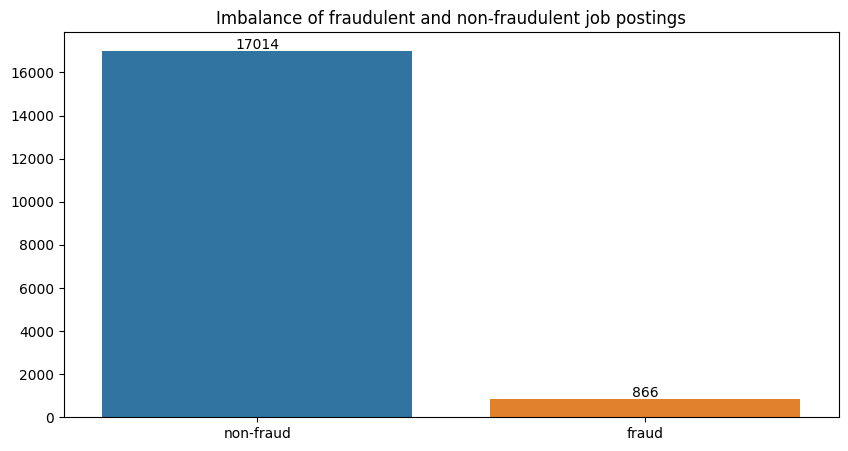

In [141]:
# plot imbalance with barplot
fig = plt.figure(figsize=(10, 5))
# create barplot with 2 bars: fraud and non-fraud
non_fraud, fraud = df['fraudulent'].value_counts()
sns.barplot(x=['non-fraud', 'fraud'], y=[non_fraud, fraud])
plt.title('Imbalance of fraudulent and non-fraudulent job postings')
plt.text(x=0, y=non_fraud+100, s=non_fraud, ha='center')
plt.text(x=1, y=fraud+100, s=fraud, ha='center')
plt.show()

Therefore with `stratify` the proportion of `fraudulent` will be the same in `test` and `train` datasets:

In [142]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('fraudulent', axis=1), df['fraudulent'], test_size=0.2, stratify=df['fraudulent'])
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

X_train shape: (14304, 16), X_test shape: (3576, 16), y_train shape: (14304,), y_test shape: (3576,)


In [143]:
def get_fraudulent_rate(df):
    return df.mean()

def get_fraudulent_sum(df):
    return df.sum()

def get_fraudulent_proportion(val1, val2):
    hundert_percent = val1 + val2
    return val1*100 / hundert_percent, val2*100 / hundert_percent

In [144]:
print(f'Test dataset  rate: {get_fraudulent_rate(y_test):.6f}')
print(f'Train dataset rate: {get_fraudulent_rate(y_train):.6f}')

print(f'Test dataset  fraud count: {get_fraudulent_sum(y_test)}')
print(f'Train dataset fraud count: {get_fraudulent_sum(y_train)}')

proportion = get_fraudulent_proportion(get_fraudulent_sum(y_test), get_fraudulent_sum(y_train))
print(f"Proportion (train, test): ({proportion[0]:.0f}%, {proportion[1]:.0f}%)")

Test dataset  rate: 0.048378
Train dataset rate: 0.048448
Test dataset  fraud count: 173
Train dataset fraud count: 693
Proportion (train, test): (20%, 80%)


### Complex Features

In [145]:
complex_features

['location', 'salary_range']

#### Location

In [146]:
missing_location = df[df.location.isnull()]

In [147]:
# plots relation between missing location and other variables
def plot_relation(all, missing, variable):
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['All Data', 'Missing location'])

    fig.add_trace(go.Pie(labels=all[variable], values=all.counts), 
                row = 1, col = 1)

    fig.add_trace(go.Pie(labels=missing[variable], values=missing.counts), 
                row = 1, col = 2)

    fig.update_layout(title_text=f'Relation between missing location and {variable}')
    return fig

def plot_feature(df, variable, text):
    fig = go.Figure(data=[go.Pie(labels=df[variable], values=df.counts)])
    #fig.update_layout(title_text=f'Relation between {text} and {variable}')
    return fig

# makes a dataframe with the counts of the values below the threshold
def make_dataframe_based_on_counts_and_sum_low(df, variable, threshold, is_missing=False):
    if not is_missing:
        df = df[variable].value_counts().rename_axis(variable).reset_index(name='counts')
    # get the values below the threshold
    low_df = df.where(df['counts'] <= threshold).dropna().sort_values(by='counts', ascending=False)
    # count and sum
    new_row = pd.Series({variable: f'{low_df.counts.count()} other {variable}s below {threshold}', 
                        'counts': low_df.counts.sum()})
    # add the new row after removing the low values
    df = df.where(df['counts'] > threshold).dropna().sort_values(by='counts', ascending=False)
    df = pd.concat([df, 
                    pd.DataFrame([new_row], 
                                 columns=new_row.index)]
                   ).reset_index(drop=True)
    return df

# makes the dataframe for the missing location
def make_df_missing_location(df, variable):
    return df[variable].value_counts().rename_axis(variable).reset_index(name='counts')

The relation to which features

In [148]:
relations = binary_features + categorial_features
relations.remove('employment_type')
relations

['telecommuting',
 'has_company_logo',
 'has_questions',
 'department',
 'required_experience',
 'required_education',
 'industry',
 'function']

Plot with every feature:

In [149]:
subtitles = []
i = 0
for relation in relations:
    subtitles.append(f'{relation} - All Data')
    subtitles.append(f'{relation} - Missing location')
    
fig = make_subplots(rows=len(relations), 
                    cols=2, 
                    specs=[[{'type':'domain'}, {'type':'domain'}]]*len(relations),
                    subplot_titles=subtitles,
                    shared_yaxes=True)

thresholds = {'department': [1, 50],
              'salary_range': [1, 30],
              'telecommuting': [1, 30],
              'has_company_logo': [1, 30],
              'has_questions': [1, 30],
              'required_experience': [0, 30],
              'required_education': [0, 30],
              'industry': [2, 100], 
              'function': [2, 300]}

for i, relation in enumerate(relations):    
    feature = make_df_missing_location(missing_location, relation)
    feature_missing = make_dataframe_based_on_counts_and_sum_low(feature, relation, thresholds[relation][0], is_missing=True)
    feature_location = make_dataframe_based_on_counts_and_sum_low(X_test, relation, thresholds[relation][1])
    fig.add_trace(go.Pie(labels=feature_location[relation], values=feature_location.counts), row=i+1, col=1)
    fig.add_trace(go.Pie(labels=feature_missing[relation], values=feature_missing.counts), row=i+1, col=2)
fig.update_layout(title_text='Relation between missing location and other variables',
                  width=1200, height=2000,
                  margin=dict(l=0, r=0, t=100, b=0))
fig.show()

Conclusion: Missing mostly at Random, therefore no data imputing possible: drop NaN values!

##### Split Location <br>
Splitting into Country, City and State

There are 2% missing data -> drop NaN values

In [150]:
# drop all rows with missing values in location
X_train = X_train.dropna(subset=['location'])
X_train.shape

(14021, 16)

In [151]:
location_split = list(X_test['location'].str.split(',').values)
location_split[:10]

[['US', ' OR', ' NE Portland'],
 ['US', ' CA', ' West Hollywood'],
 ['UA', ' ', ' '],
 ['US', ' NY', ' Niagara Falls'],
 ['US', ' CA', ' El Segundo'],
 ['US', ' CA', ' SAN DIEGO'],
 ['US', ' TX', ' Houston'],
 ['US', ' MA', ' Boston'],
 ['GR', ' M', ' Agios Nikolaos'],
 ['US', ' NY', ' New York']]

#### Salary Range